# SD211 TP1 Systèmes de recommandation
*ZHAO Fubang*

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as  plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import check_grad
from scipy import linalg
%matplotlib inline

# 1 Présentation du modèle
## Question 1.1

In [2]:
def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

In [3]:
R, mask = load_movielens('ml-100k/u.data', minidata=False)
print R.shape, mask.shape

(943, 1682) (943, 1682)


## Reponse:
L'option minidata est pour juste choisir un dataset de taille 100*200 donc on peut réduire le temps de calculation.

## Question 1.2

In [4]:
print np.nonzero(R)[0].shape

(100000,)


## Reponse:

Selon le taille de R et le nombre de non_zero valeurs, on peut voir que:
1. Le nombre d'utilisateurs: 943;
2. Le nombre de films: 1682;
3. Le nombre total de notes: 100000

## Question 1.3

In [5]:
def objSimple(P, Q, R, rho):
    tmp = R - Q*P
    val = (tmp ** 2)/2. + rho/2. * (Q ** 2 + P ** 2)
    return val

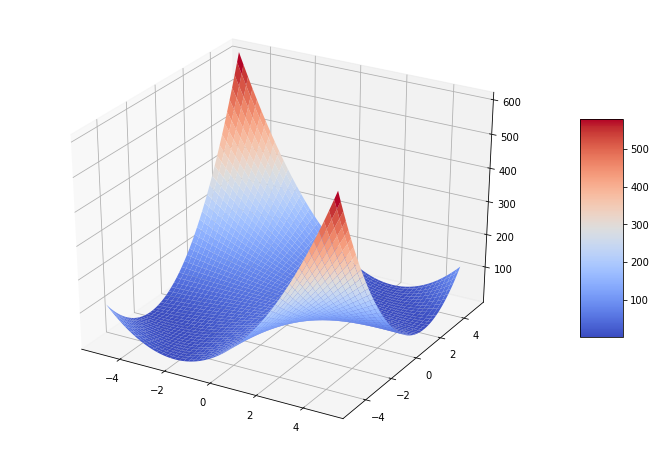

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

# Make data.
P = np.arange(-5, 5, 0.05)
Q = np.arange(-5, 5, 0.05)
P, Q = np.meshgrid(P, Q)
Z = objSimple(P, Q, 10, 0.2)

# Plot the surface.
surf = ax.plot_surface(P, Q, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Reponse:
On prend une situation extrême, c'est à dire qu'on utilise les nombres pour remplacer les matrices.
Selon le graphe, on peut voir que le minimum n'est pas au milieu du surface. Donc, c'est pas convexe.

# 2 Trouver $P$ quand $Q_0$ est fixé
## Question 2.1

$$g(P) = \frac{1}{2}\|1_K\circ(R - Q^0P)\|^2_F+\frac{\rho}{2}\|Q^0\|^2_F+\frac{\rho}{2}\|P\|^2_F$$
<br>
$$\triangledown g(P) = - (Q^0)^T(1_K \circ (R - Q^0P)) + \rho P$$
<br>
$${\triangledown} ^2 g(P) = (Q^0)^TQ^0 + \rho I$$<br>
Il est évident que la matrice est définie positive, donc $g(P)$ est convexe.<br>
Son gradient est $\triangledown g(P) = (Q^0)^T((Q^0P - R)\circ 1_K) + \rho P$

## Question 2.2

In [7]:
def func(P_ravel, Q0, R, mask, rho, c):
    P = P_ravel.reshape((c, P_ravel.shape[0]/c))
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    return val

def grad(P_ravel, Q0, R, mask, rho, c):
    P = P_ravel.reshape((6, P_ravel.shape[0]/c))
    tmp = (R - Q0.dot(P)) * mask
    grad_P = -Q0.T.dot(tmp) + rho * P
    return grad_P.ravel()

In [4]:
U, s, Vh = linalg.svd(R)
c = 6
rho = 0.2
Q0 = U[:, :c]
P0 = Vh[:c, :]
check_grad(func, grad, P0.ravel(), Q0, R, mask, rho, c)

NameError: name 'linalg' is not defined

## Reponse:
On verifie le calcul par *check_grad*. D'abord, il faut séparer la fonction *objective* à deux fonctions: *func* et *grad*. Après, il faut changer le paramètre *P* à un array(C'est à dire qu'il faut le reformer à un matrice. Selon le résultat de *check_grad*, on peut voir que les deux gradients sont presque égales.

## Question 2.3

In [3]:
def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    grad_P = -Q0.T.dot(tmp) + rho * P
    return val, grad_P


def gradient(g, P0, gamma, epsilon):
    values = []
    new_value, grad = g(P0, Q0, R, mask, rho)
    values.append(new_value)
    while np.sum((grad) ** 2) ** 0.5 > epsilon:
        step = -gamma * grad / (np.sum(grad ** 2) ** 0.5)
        P0 = P0 + step
        new_value, grad = g(P0, Q0, R, mask, rho)
        values.append(new_value)
    return new_value, values

## Question 2.4

The minimal value is: 303938.27
The iteration times are: 1128


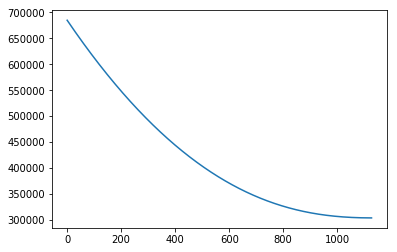

In [12]:
v, vs = gradient(objective, P0, 1, 1)
print 'The minimal value is: %.2f' %v
print 'The iteration times are: %r' %len(vs)
plt.figure()
plt.plot(vs)
plt.show()

# 3 Raffinements algorithmiques pour le problème à $Q_0$ fixé
## Question 3.1

In [118]:
def gradientRecLin(g, P0, epsilon):
    values = []
    new_value, grad = g(P0, Q0, R, mask, rho)
    values.append(new_value)
    while np.sum((grad) ** 2) ** 0.5 > epsilon:
        temp1 = rho*np.sum(grad*P0) - np.sum((Q0.dot(grad)*(R - Q0.dot(P0))*mask)) 
        temp2 = rho*np.sum((grad)**2) + np.sum((Q0.dot(grad)*mask)**2)
        y = temp1/temp2
        P0 = P0 - y*grad
        new_value, grad = g(P0, Q0, R, mask, rho)
        values.append(new_value)
    return new_value, values

The minimal value is: 303937.25
The iteration times are: 12


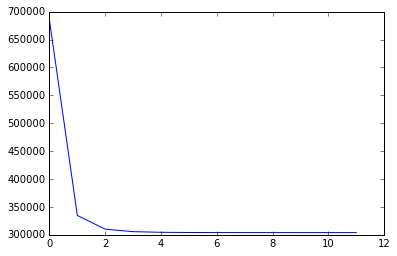

In [123]:
v_r, vs_r = gradientRecLin(objective, P0, 1)
print 'The minimal value is: %.2f' %v_r
print 'The iteration times are: %r' %len(vs_r)
plt.figure()
plt.plot(vs_r)
plt.show()

## Question 3.2
#### Théorème:
Soit $q(x) = \frac{1}{2}x^t A x + b^t x + c$ une fonction quadratique, où A est une matrice symétrique définie positive. On peut utiliser le méthode des gradients conjugués.

\begin{align}
g(P) &= \frac{1}{2}\|1_K\circ(R - Q^0P)\|^2_F+\frac{\rho}{2}\|Q^0\|^2_F+\frac{\rho}{2}\|P\|^2_F\\
&= Tr[\frac{1}{2}(1_K \circ (R - Q_0P))^T(1_K \circ (R - Q_0P)) + \frac{\rho}{2}P^T P ] + \frac{\rho}{2}\|Q_0\|^2_F
\end{align}

Pour transformer le calcul de matrice au celui de vecteur, on définit quelques variables:

$X = P.reshape(CI,1) = 
\begin{Bmatrix}
        P_{1} \\
        P_{2} \\
        \vdots \\
        P_{I-1} \\
        P_{I} \\
\end{Bmatrix}$

$R' = R.reshape(UI,1) = 
\begin{Bmatrix}
        R_{1} \\
        R_{2} \\
        \vdots \\
        R_{I-1} \\
        R_{I} \\
\end{Bmatrix}$

$Q' = 
\begin{Bmatrix}
    Q_0 & 0 & \cdots & 0 \\
    0 & Q_0 & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & Q_0 \\
\end{Bmatrix} $
<br>
(Q'.shape = $UI*CI$)

$M' = 
\begin{Bmatrix}
    mask_{1, 1} & 0 & \cdots & 0 \\
    0 & mask_{2, 1} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & mask_{U, I} \\
\end{Bmatrix} $
<br>
(M'.shape = $UI*UI$)

On définit que $f(X)=g(P)$, et:
\begin{align}
f(x) & = g(P) \\
& = Tr[\frac{1}{2}(1_K \circ (R - Q_0P))^T(1_K \circ (R - Q_0P)) + \frac{\rho}{2}P^T P ] + \frac{\rho}{2}\|Q_0\|^2_F \\
& = \frac{1}{2}(M'*(R'-Q'X))^T(M'*(R'-Q'X)) + \frac{\rho}{2}X^TX + \frac{\rho}{2}\|Q_0\|^2_F\\
& = \frac{1}{2}(X^T((M'Q')^TM'Q' + \rho I_d)X - 2R'^TM'Q'X + R'^TM'R') + \frac{\rho}{2}\|Q_0\|^2_F \\
\end{align}
On a que:<br>
$A = Q'^TM'Q' + \rho I_{CI}$

$b^t = -R'^TM'Q'$

$c = \frac{1}{2}R'^TM''R' + \frac{\rho}{2}\|Q_0\|^2_F$

et:<br>
$f(x) = \frac{1}{2}x^t A x + b^t x + c$<br>
Il est évident que A est définie positive, donc on peut utiliser la méthode des gradients conjugués.
Car pour ce problème, c'est pas pratique de transformer tous les matrices aux vecteurs, on utilise un algorithme pour la fonction quelconque lors de calculer le résultat numérique.

In [169]:
def gradientGc(g, P0, epsilon):
    values = []
    new_value, grad = g(P0, Q0, R, mask, rho)
    d0 = grad
    values.append(new_value)
    while np.sum((grad) ** 2) ** 0.5 > epsilon:
        temp1 = rho*np.sum(d0*P0) - np.sum((Q0.dot(d0)*(R - Q0.dot(P0))*mask)) 
        temp2 = rho*np.sum((d0)**2) + np.sum((Q0.dot(d0)*mask)**2)
        y = temp1/temp2
        P0 = P0 - y*d0
        grad_old = grad
        new_value, grad = g(P0, Q0, R, mask, rho)
        values.append(new_value)
        b = np.sum(grad ** 2)/np.sum(grad_old ** 2)
        d0 =  grad + b * d0
    return new_value, values

The minimal value is: 303936.98
The iteration times are: 8


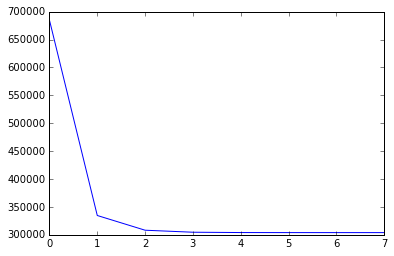

In [191]:
v_gc, vs_gc = gradientGc(objective, P0, 1)
print 'The minimal value is: %.2f' %v_gc
print 'The iteration times are: %r' %len(vs_gc)
plt.figure()
plt.plot(vs_gc)
plt.show()

## Question 3.3
Pour minimiser la fonction jusqu'à $\epsilon<=1$:
1. La méthode de gradient a besoins de 1128 fois d'itération avec $\gamma=1$, le valeur mnimal est 303938.38.
2. La méthode de recherche linéaire a besoins de 12 fois d'itération , le valeur mnimal est 303937.25 qui est plus petit que la méthode de gradient.
3. La méthode de gradient conjugué a besoins de juste 8 fois d'itération , le valeur mnimal est 303936.98 qui est plus petit que la méthode de gradient.

#Résolution du problème complet
## Question 4.1

In [13]:
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = -Q0.T.dot(tmp) + rho * P

    grad_Q = -tmp.dot(P0.T) + rho * Q

    return val, grad_P, grad_Q


def gradientRecLinP(g, P00, Q00, epsilon):
    new_value, grad, _ = g(P00, Q00, R, mask, rho)
    k = 0
    while k < 30:
        temp1 = rho*np.sum(grad*P00) - np.sum(Q00.dot(grad)*(R - Q00.dot(P00))*mask) 
        temp2 = rho*np.sum((grad)**2) + np.sum((Q00.dot(grad)*mask)**2)
        y = temp1/temp2
        P00 = P00 - y*grad
        new_value, grad, _ = g(P00, Q00, R, mask, rho)
        k = k + 1
    return new_value, P00

def gradientRecLinQ(g, P00, Q00, epsilon):
    new_value, _, grad = g(P00, Q00, R, mask, rho)
    k = 0
    while k < 30:
        temp1 = rho*np.sum(grad*Q00) - np.sum(grad.dot(P00)*(R - Q00.dot(P00))*mask) 
        temp2 = rho*np.sum((grad)**2) + np.sum((grad.dot(P00)*mask)**2)
        y = temp1/temp2
        Q00 = Q00 - y*grad
        new_value, _, grad = g(P00, Q00, R, mask, rho)
        k = k + 1
    return new_value, Q00

def gradientTotal(P00, Q00, epsilon, times):
    k = 0
    values = []
    P11, Q11 = P00, Q00
    while k < times:
        v, Q11 = gradientRecLinQ(total_objective, P11, Q11, epsilon)
        values.append(v)
        v, P11 = gradientRecLinP(total_objective, P11, Q11, epsilon)
        values.append(v)
        k = k + 1
    return v, values, P11, Q11

In [14]:
P1 = np.ones(P0.shape)
Q1 = np.ones(Q0.shape)
print P1.shape, Q1.shape

(6, 1682) (943, 6)


The minimal value is: 99285.77
The iteration times are: 10


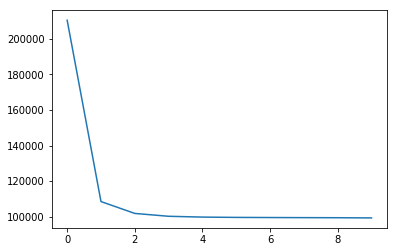

In [15]:
v_t, vs_t, P_rl, Q_rl = gradientTotal(P1, Q1, 100, 5)
print 'The minimal value is: %.2f' %v_t
print 'The iteration times are: %r' %len(vs_t)
plt.figure()
plt.plot(vs_t)
plt.show()

## Question 4.2
*for  k >= 1 do*

$$P_k = argmin_P(\frac{1}{2}(1_K \circ ||R-Q_{k-1}P||_F^2) + \frac{\rho}{2}(||P||_F^2 + ||Q_{k-1}||_F^2)$$

$$Q_k = argmin_Q(\frac{1}{2}(1_K \circ ||R-QP_k||_F^2) + \frac{\rho}{2}(||P_k||_F^2 + ||Q||_F^2)$$

*end for*<br>
Pour ce problème, la fonction est toujours convexe par rapport à Q et P. Donc à chaque étape, l'objectif décroît. Cependant, on peut seulement avoir le minimum local car la fonction n'est pas convexe lorque tous Q et P ne sont pas fixé;

## Question 4.3

## Question 4.4

## Question 4.5

In [16]:
resLS = np.argmax((Q_rl[449,:].dot(P_rl))*(1 - mask[449,:]))

print(resLS)

951


Le meillieur film pour utilisateur 449 est: 951